<hr style="border:2px solid Teal"> </hr>

# Speech Coding Strategies for Cochlear Implants

<hr style="border:2px solid Teal"> </hr>

In [238]:
using PyPlot
using WAV
using DSP
using FFTW

In [239]:
include("src/utils.jl")
include("src/plotting.jl");

In [240]:
path = "./data/"
file = "PR-open_front_unrounded_vowel.wav"
file = "add_the_sum.wav"
file = "OSR_us_000_0010_8k.wav"
wav_file = wavread(string(path,file));
audio_orig = wav_file[1][:,1]; # just one channel
Fs = wav_file[2]; # sampling rate

# First 3.5ms
time_end = convert(Int, 3.5 * Fs)
time = (0:time_end-1)/Fs
audio_orig = audio_orig[1:time_end];

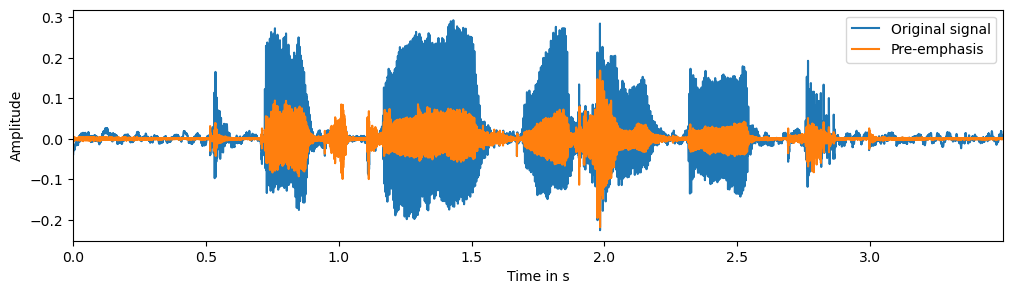

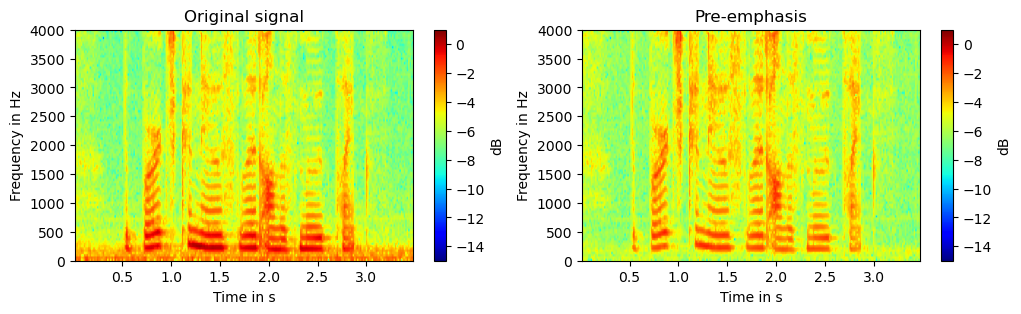

In [241]:
audio = pre_emph(audio_orig)

figure(figsize=(12,3))
plot_audio(time,audio_orig)
plot_audio(time,audio)
legend(["Original signal", "Pre-emphasis"])

figure(figsize=(12,3))
subplot(1,2,1)
plot_spectrogram(audio_orig, Fs)
title("Original signal")
subplot(1,2,2)
plot_spectrogram(audio, Fs)
title("Pre-emphasis");

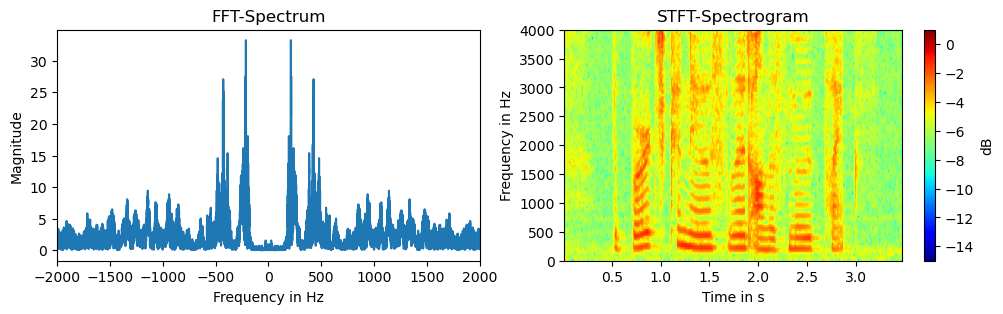

In [242]:
audio_fft = fft(audio)
audio_fft = FFTW.fftshift(audio_fft)

freqs = FFTW.fftfreq(length(time), Fs)
freqs = FFTW.fftshift(freqs)

figure(figsize=(12,3))

subplot(1,2,1)
plot(freqs,abs.(audio_fft))
xlim([-2000,2000])
xlabel("Frequency in Hz")
ylabel("Magnitude")
title("FFT-Spectrum")

subplot(1,2,2)
plot_spectrogram(audio, Fs)
#ylim([0,8000])
title("STFT-Spectrogram");

<hr style="border:2px solid black"> </hr>

### House/3M Single Channel CI [fretz+1985]

![title](img/House_3M_Single_Channel_CI.png)


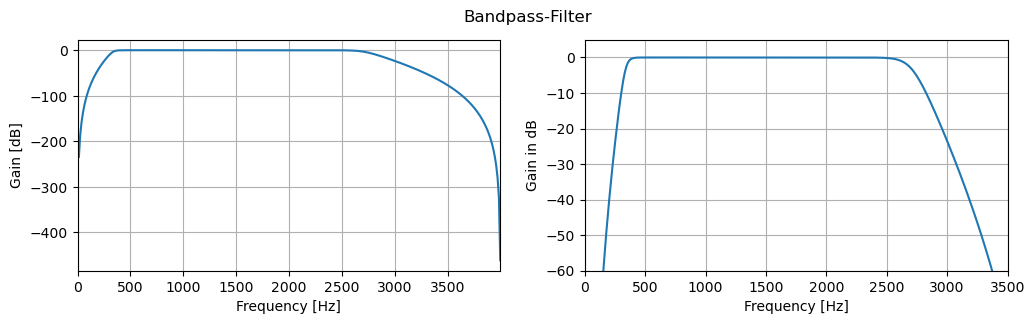

In [243]:
responsetype = Bandpass(340,2700; fs=Fs);
prototype = Butterworth(8);
cochlear_filter = digitalfilter(responsetype, prototype);

ω = 0:0.01:pi 
H = freqz(cochlear_filter, ω)

figure(figsize=(12,3))

suptitle("Bandpass-Filter")
subplot(1,2,1)
plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
xlabel("Frequency [Hz]")
ylabel("Gain [dB]")
xlim([0,last(Fs/2*ω/pi)])
grid()

subplot(1,2,2)
plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
xlabel("Frequency [Hz]")
ylabel("Gain in dB")
xlim([0,3500])
ylim([-60,5])
grid()

# Filtering the input signal
audio_filt = filt(cochlear_filter, audio);

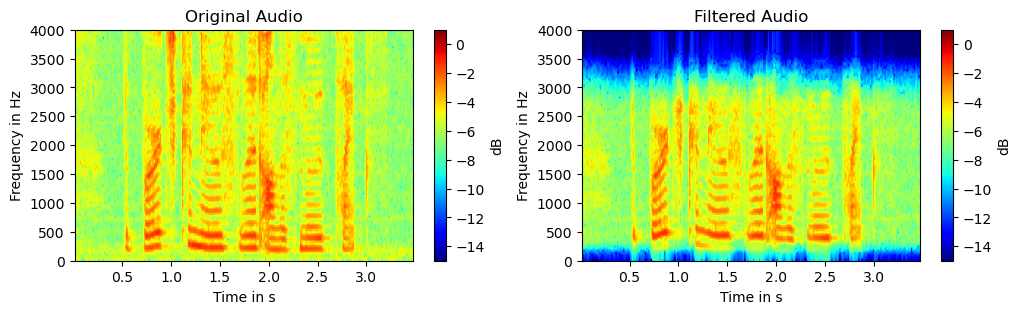

In [244]:
figure(figsize=(12,3))
subplot(1,2,1)
plot_spectrogram(audio, Fs)
#ylim([0,5000])
title("Original Audio")

subplot(1,2,2)
plot_spectrogram(audio_filt, Fs)
#ylim([0,5000])
title("Filtered Audio");

In [245]:
f = 16e3
if f > Fs/2
    f = Fs/8
end
    
f_carr = sin.(2*pi*f.*time)
f_electrode = f_carr .* audio_filt;

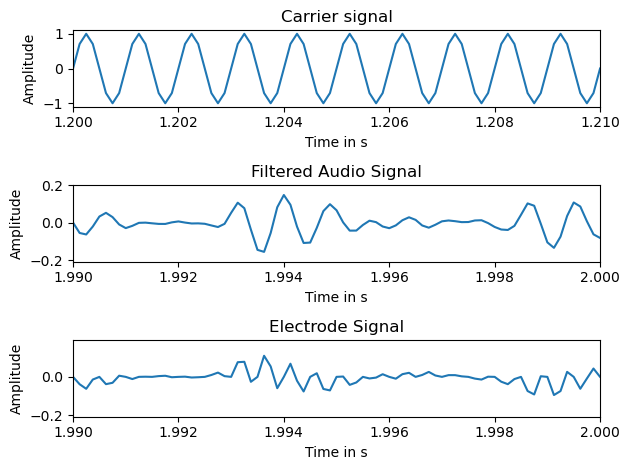

In [246]:
subplot(3,1,1)
plot_audio(time,f_carr)
xlim([1.2,1.21])
title("Carrier signal")

subplot(3,1,2)
plot_audio(time,audio_filt)
xlim([1.99,2])
title("Filtered Audio Signal")

subplot(3,1,3)
plot_audio(time, f_electrode)
xlim([1.99,2])
title("Electrode Signal")

tight_layout()

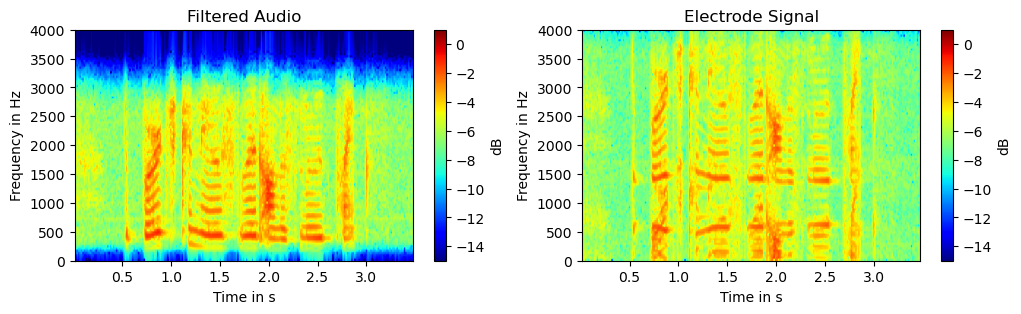

In [247]:
figure(figsize=(12,3))
subplot(1,2,1)
plot_spectrogram(audio_filt, Fs)
#ylim([0,5000])
title("Filtered Audio")

subplot(1,2,2)
plot_spectrogram(f_electrode, Fs)
#ylim([0,5000])
title("Electrode Signal");

<hr style="border:2px solid black"> </hr>

### Multi-channel Analog CI

![title](img/Multi_channel_Analog_CI.png)


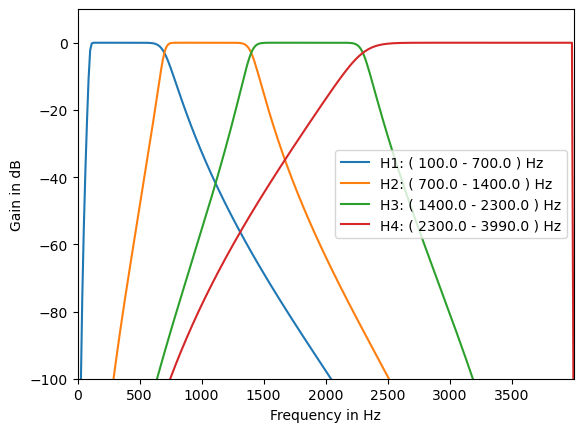

PyObject <matplotlib.legend.Legend object at 0x00000000901B7CA0>

In [248]:
freq_passband = [[0.1,0.7]   [0.7,1.4]    [1.4,2.3]   [2.3, 3.99]]*1e3

filter_output = zeros(4,length(audio))
ω = 0:0.01:pi 

legend_str = Array{Union{Nothing, String}}(nothing, 4)
for i in 1:4
    responsetype = Bandpass(freq_passband[1,i], freq_passband[2,i]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, ω)
    plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
    xlim([0,last(Fs/2*ω/pi)])
    ylim([-100,10])
    xlabel("Frequency in Hz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
    legend_str[i] = string("H",i,": ","( ",freq_passband[1,i]," - ",freq_passband[2,i]," ) Hz")
end
legend(legend_str)

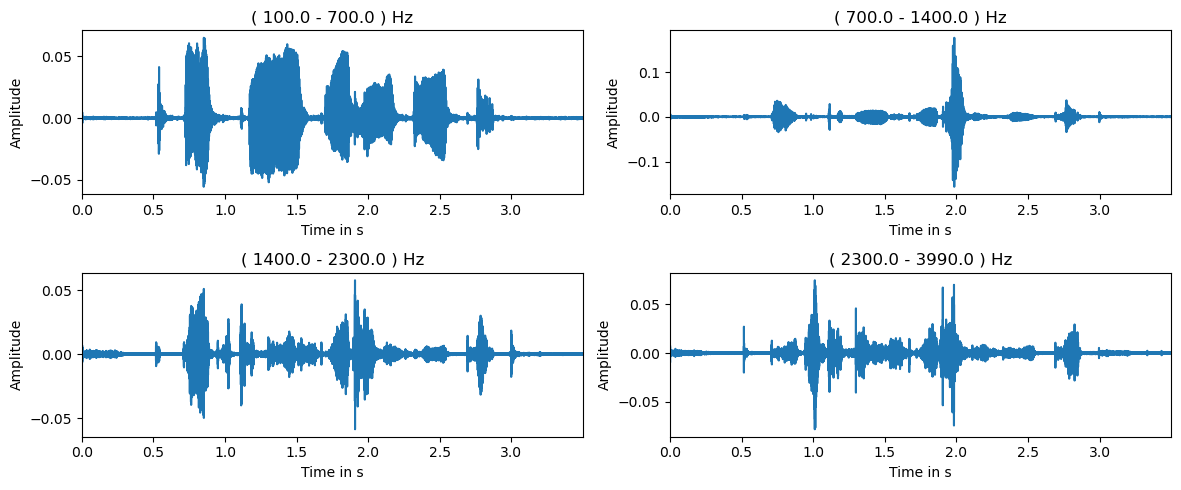

In [249]:
figure(figsize=(12,5))

for i in 1:4
    subplot(2,2,i)
    plot_audio(time,filter_output[i,:])
    title(string("( ",freq_passband[1,i]," - ",freq_passband[2,i]," ) Hz"))
end
tight_layout()

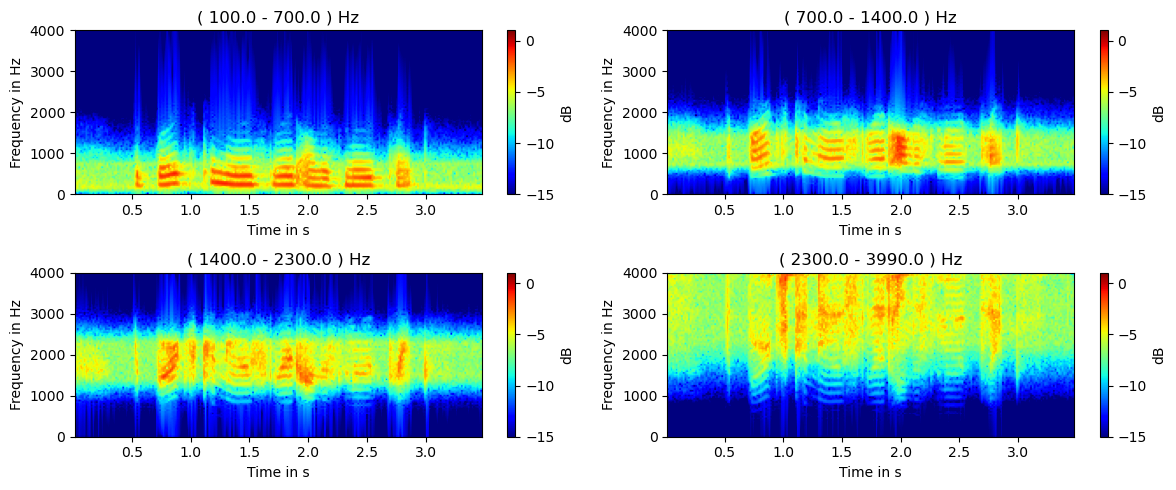

In [250]:
figure(figsize=(12,5))

for i in 1:4
    subplot(2,2,i)
    plot_spectrogram(filter_output[i,:], Fs)
    title(string("( ",freq_passband[1,i]," - ",freq_passband[2,i]," ) Hz"))
    #ylim([1, freq_passband[2,i]]*2.5)
end
tight_layout()

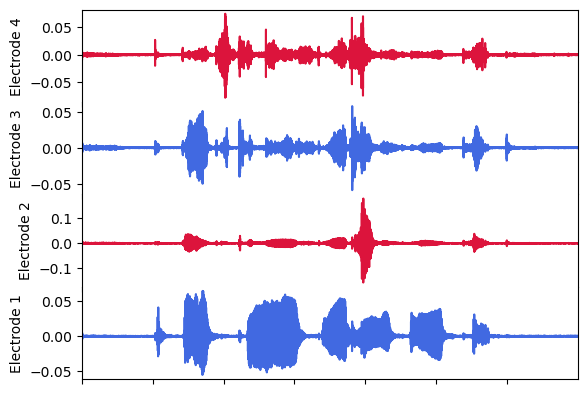

In [251]:
ax = [plt.subplot(4,1,i) for i in (1:4)]
colors = ["royalblue", "crimson"]

for (i,a) in enumerate(ax)
    a.set_xticklabels([])
    #a.set_yticklabels([])
    #a.set_ylim([-0.2,0.2])
    a.plot(time,filter_output[5-i,:], color = colors[mod1(5-i,2)])
    a.set_xlim([0,last(time)])
    a.set_ylabel(string("Electrode ", 5-i))
end

for i in 2:4
    down_side = ax[i-1].spines["bottom"]
    down_side.set_visible(false) 
    up_side = ax[i].spines["top"]
    up_side.set_visible(false) 
end

plt.subplots_adjust(wspace=0, hspace=0)

wavplay(filter_output[3,:],Fs)

<hr style="border:2px solid black"> </hr>

### Feature Extraction Strategy F0-F2

![title](img/feature_f0_f2.png)

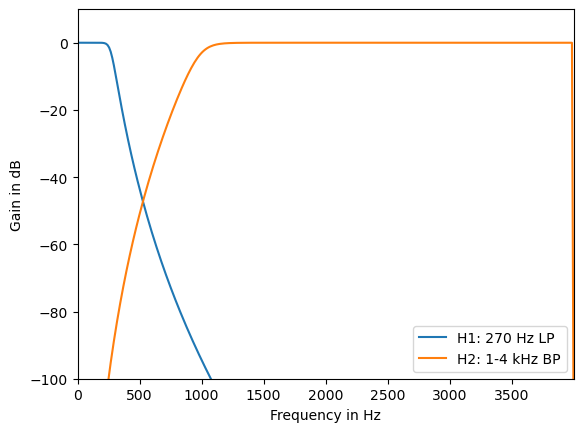

In [252]:
filter_output = zeros(2,length(audio))
ω = 0:0.01:pi 

prototype = Butterworth(8);

responsetype = Lowpass(270; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_low = freqz(cochlear_filter, ω)
filter_output[1,:] = filt(cochlear_filter, audio);

responsetype = Bandpass(1e3, 3.99e3; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_bp = freqz(cochlear_filter, ω)
filter_output[2,:] = filt(cochlear_filter, audio);

plot(Fs/2*ω/pi, 20*log10.(abs.(H_low)))
plot(Fs/2*ω/pi, 20*log10.(abs.(H_bp)))
xlim([0,last(Fs/2*ω/pi)])
ylim([-100,10])
xlabel("Frequency in Hz")
ylabel("Gain in dB")
legend(("H1: 270 Hz LP","H2: 1-4 kHz BP"));

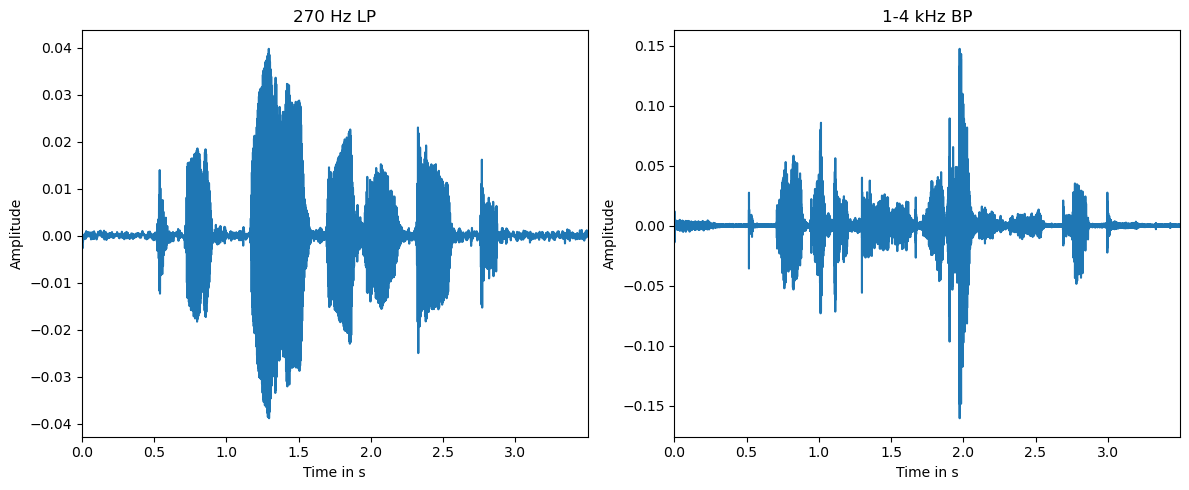

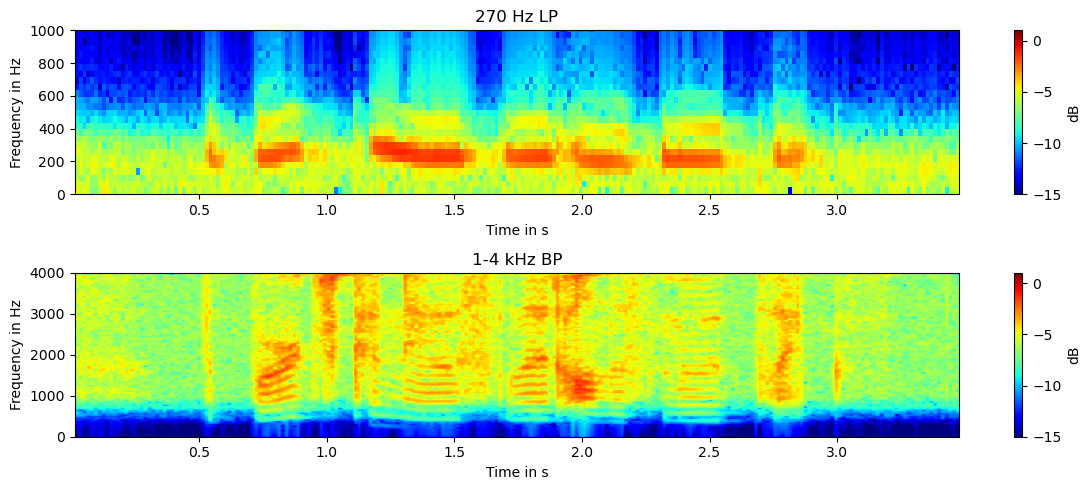

In [253]:
figure(figsize=(12,5))
title_str = ["270 Hz LP", "1-4 kHz BP"]

for i in 1:2
    subplot(1,2,i)
    plot_audio(time,filter_output[i,:])
    title(title_str[i])
end

tight_layout()

figure(figsize=(12,5))
subplot(2,1,1)
plot_spectrogram(filter_output[1,:], Fs)
ylim([0,1000])
title(title_str[1])
subplot(2,1,2)
plot_spectrogram(filter_output[2,:], Fs)
#ylim([800,5000])
title(title_str[2])

tight_layout()

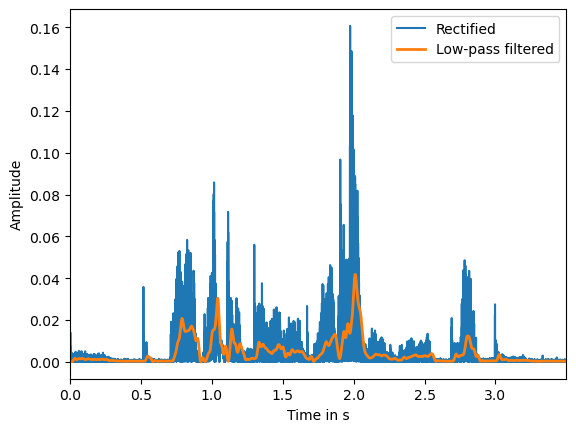

In [254]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);
rect_audio = abs.(filter_output[2,:])
rect_low = filt(lp_filter, rect_audio);

plot_audio(time,rect_audio)
plot(time,rect_low,lw=2)
legend(["Rectified", "Low-pass filtered"]);

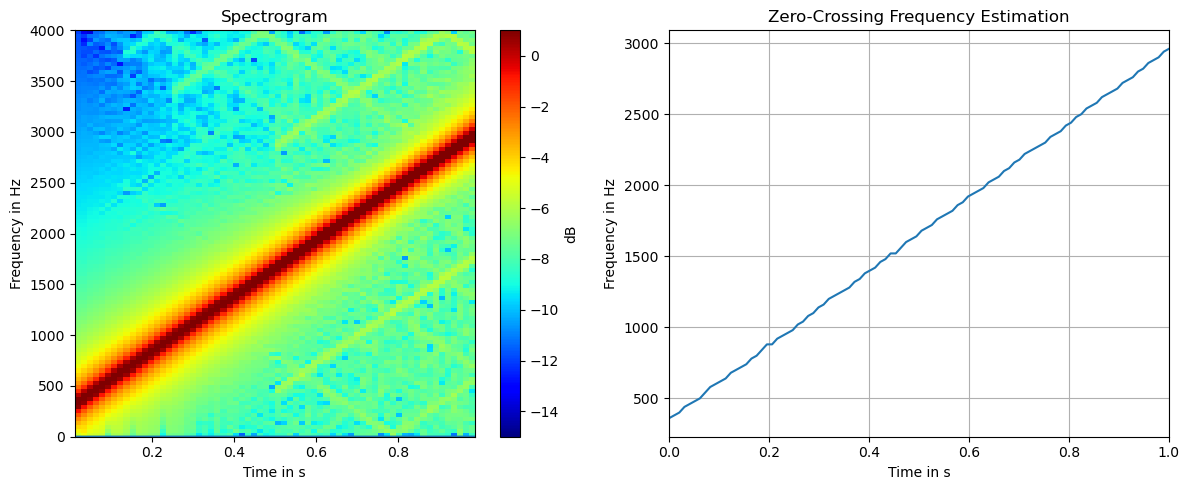

In [255]:
####################################################################################
# Testing if splitting in frames and estimation frequency with zero crossings works
####################################################################################

using SignalAnalysis

x = chirp(3e2, 3e3, 1, Fs)

signal_frames_chirp = generate_frames(real.(x),Fs);
time_frames = collect( range(0,1,length=size(signal_frames_chirp)[1]) )

F_chirp = zeros((size(signal_frames_chirp)[1],1))

for (idx,i) in enumerate(1:(size(signal_frames_chirp)[1]))
    ZCR = zero_crossings(convert(Array{Float64,1}, signal_frames_chirp[i,:]))
    F_chirp[idx] = ZCR/length(signal_frames_chirp[i,:])*Fs/2
end

figure(figsize=(12,5))
subplot(1,2,1)
plot(real.(x))
plot_spectrogram(real.(x), Fs)
#ylim([4000,16000])
title("Spectrogram")

subplot(1,2,2)
plot(time_frames,F_chirp)
xlim([0,last(time_frames)])
#ylim([4000,16000])
xlabel("Time in s")
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation")
grid()
tight_layout()

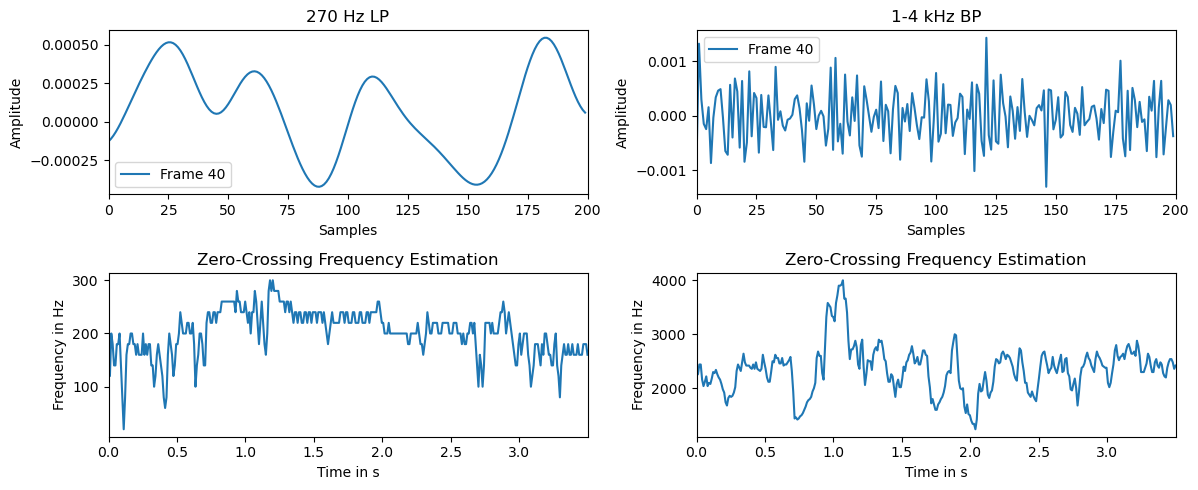

In [256]:
signal_frames_F0 = generate_frames(filter_output[1,:],Fs);
signal_frames_F2 = generate_frames(filter_output[2,:],Fs);
frame_length = size(signal_frames_F0)[2]
number_frames = size(signal_frames_F0)[1]
time_frames = collect( range(0,last(time),length=number_frames) )

figure(figsize=(12,5))
subplot(2,2,1)
plot(signal_frames_F0[40,:])
xlim([0,frame_length])
legend(["Frame 40"])
xlabel("Samples")
ylabel("Amplitude")
title(title_str[1])
subplot(2,2,2)
plot(signal_frames_F2[40,:])
xlim([0,frame_length])
legend(["Frame 40"])
xlabel("Samples")
ylabel("Amplitude")
title(title_str[2])

F0_ZC = zeros((number_frames,1))
F2_ZC = zeros((number_frames,1))

for (idx,i) in enumerate(1:(size(signal_frames_F0)[1]))
    ZCR_F0 = zero_crossings(convert(Array{Float64,1}, signal_frames_F0[i,:]))
    F0_ZC[idx] = ZCR_F0/length(signal_frames_F0[i,:])*Fs/2
    ZCR_F2 = zero_crossings(convert(Array{Float64,1}, signal_frames_F2[i,:]))
    F2_ZC[idx] = ZCR_F2/length(signal_frames_F2[i,:])*Fs/2
end

subplot(2,2,3)
plot(time_frames,F0_ZC)
xlim([0,last(time)])
xlabel("Time in s")
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation")
subplot(2,2,4)
plot(time_frames,F2_ZC)
xlim([0,last(time)])
xlabel("Time in s")
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation")
tight_layout()

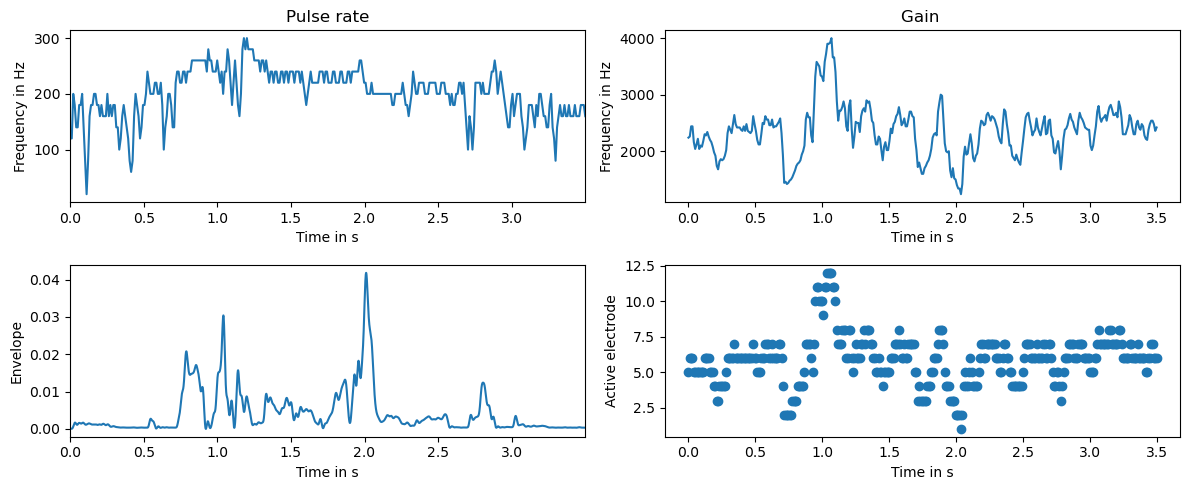

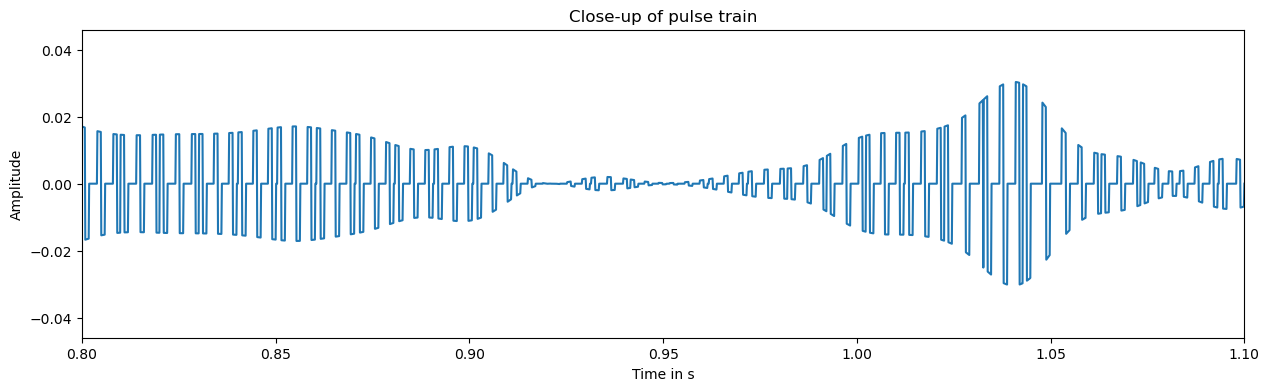

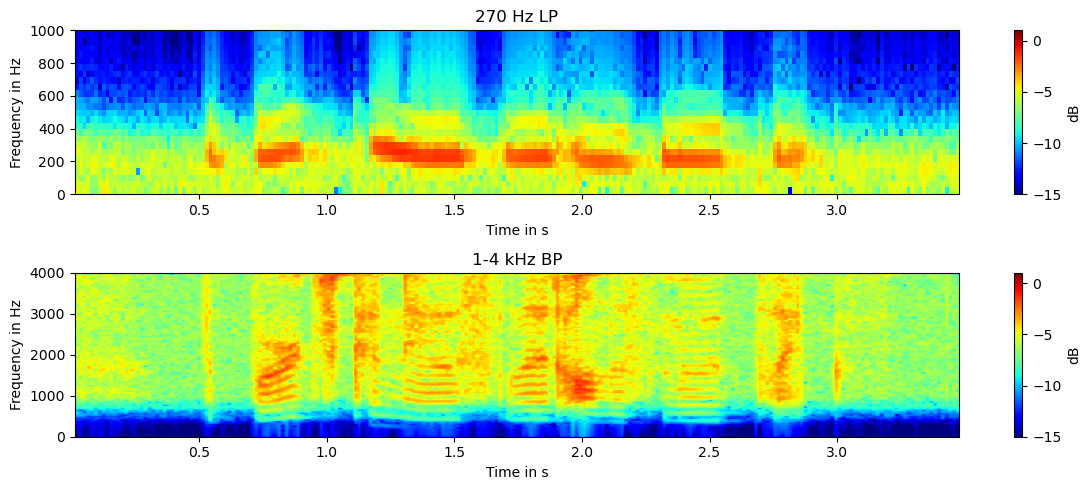

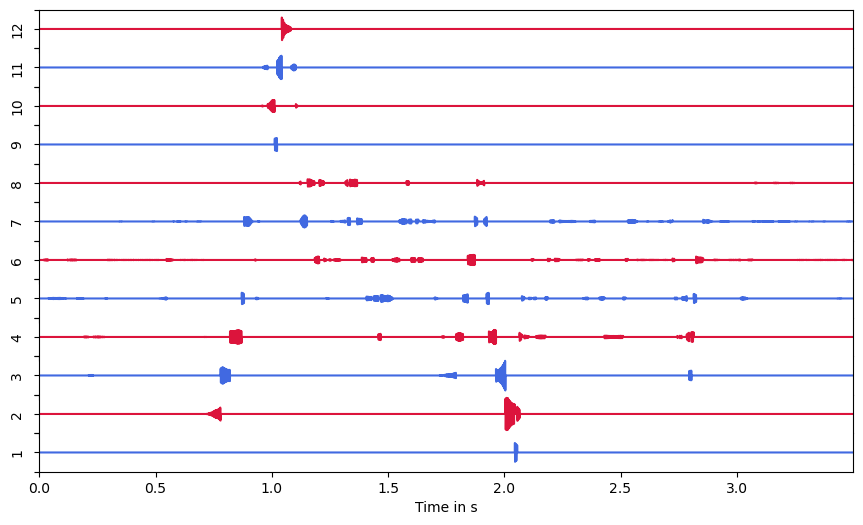

In [271]:
pulses = []
electrodes = []

N_total = convert(Int,ceil(length(audio)/number_frames))
N_period_vec = convert.( Int, round.( Fs ./ F0_ZC ) )
N_pulse = convert(Int, round(2e-3* Fs))

N_electrodes = 12
delta_freq = (4e3-1e3)/(N_electrodes)
frequency_spacing = collect( range(1e3+delta_freq,4e3,length = N_electrodes) );

electrode_signal = zeros(N_electrodes,length(audio))

for idx_frame in 1:number_frames
    
    idx_begin = (idx_frame-1)*N_total+1 
    idx_end = min(length(audio),idx_begin+N_total-1)
    idx_diff = idx_end-idx_begin
      
    N_period = N_period_vec[idx_frame]
    pulse_frame = biphasic_pulse(N_total,N_pulse,N_period)
    pulse_frame = rect_low[idx_begin : idx_end].*pulse_frame[1:idx_diff+1]
    
    append!(pulses, pulse_frame) 
    
    number_electrode = findall( F2_ZC[idx_frame] .<= frequency_spacing )
    append!(electrodes, minimum( number_electrode ) )

    electrode_signal[minimum( number_electrode ) , idx_begin : idx_end] = pulse_frame
    
end

##----------------------------------------------------------------------##
# Plots
##----------------------------------------------------------------------##

figure(figsize=(12,5))
subplot(2,2,1)
plot(time_frames,F0_ZC)
xlim([0,last(time)])
xlabel("Time in s")
ylabel("Frequency in Hz")
title("Pulse rate")

subplot(2,2,2)
plot(time_frames,F2_ZC)
xlabel("Time in s")
ylabel("Frequency in Hz")
title("Gain ")

subplot(2,2,3)
plot_audio(time,rect_low)
ylabel("Envelope")
tight_layout()

subplot(2,2,4)
scatter(time_frames,electrodes)
xlabel("Time in s")
ylabel("Active electrode")

tight_layout()

figure(figsize=(15,4))
plot_audio(time,pulses)
title("Close-up of pulse train")
xlim([0.8,1.1])
 
##----------------------------------------------------------------------##
# Plot electrodes
##----------------------------------------------------------------------##
title_str = ["270 Hz LP", "1-4 kHz BP"]
figure(figsize=(12,5))
subplot(2,1,1)
plot_spectrogram(filter_output[1,:], Fs)
ylim([0,1000])
title(title_str[1])
subplot(2,1,2)
plot_spectrogram(filter_output[2,:], Fs)
title(title_str[2])

tight_layout()
figure(figsize=(10.5,6))
ax = [plt.subplot(N_electrodes,1,i) for i in (1:N_electrodes)]
colors = ["royalblue", "crimson"]

for (i,a) in enumerate(ax)
    if a != last(ax)
        a.set_xticklabels([])
    end
    a.set_ylim([-0.05,0.05])
    a.set_yticklabels([])
    a.plot(time,electrode_signal[N_electrodes+1-i,:], color = colors[mod1(N_electrodes+1-i,2)])
    a.set_xlim([0,last(time)])
    a.set_ylabel(string(N_electrodes+1-i))
end
last(ax).set_xlabel("Time in s")
for i in 2:N_electrodes
    down_side = ax[i-1].spines["bottom"]
    down_side.set_visible(false) 
    up_side = ax[i].spines["top"]
    up_side.set_visible(false) 
end
plt.subplots_adjust(wspace=0, hspace=0)

<hr style="border:2px solid black"> </hr>

### Feature Extraction Strategy F0-F1-F2

![title](img/feature_f0_f1_f2.png)